# Overall Reactor Comparison

### This notebooks compares different reactors with respect to SNF metrics, including the repository footprint and peak dose rates

In [1]:
%matplotlib inline
import math
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as tk 

import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

pd.set_option('display.precision', 2)

# Setup

In [2]:
# Load the csv files obtained with ...
# Return a list containing the dataframe with the results for each reactors
def load_results(workspace_path, reactors, footprint_reactor):

    # Load openMC results (from script 1)
    openmc_results = []
    for reactor in reactors:
        # Read in cooling reactor data
        result = pd.read_csv(workspace_path + 'results/'+reactor+'/reactor_simulation/summary/cooling_'+reactor+'.csv', sep=',')

        # Set index to be time from reactor discharge
        result['cooling time']=(result.iloc[:, 0]-result.iloc[0, 0])/365
        result.set_index('cooling time', inplace=True)

        # Append to list
        openmc_results.append(result)

    # Load footprint minimizations (from script 2)
    footprint_results = pd.read_csv(workspace_path + '/results/'+footprint_reactor+'/repository_simulation/footprints/'+footprint_reactor+'_combined_footprints.csv')
        
    return openmc_results, footprint_results

# Function to add value labels on the bar chart
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [3]:
# Set up workspace
workspace_path = '/Users/krishnasunder/Desktop/workspace/R2R4SNF/'
reactors = ['Ref_PWR', 'SPWR', 'HTGR', 'HPR', 'HTGR_FCM','SFR']
reactors_legend = reactors 

# Load openmc and footprint minimization results
openmc_results, footprint_results = load_results(workspace_path, reactors, 'HTGR')

# SNF mass and volumes

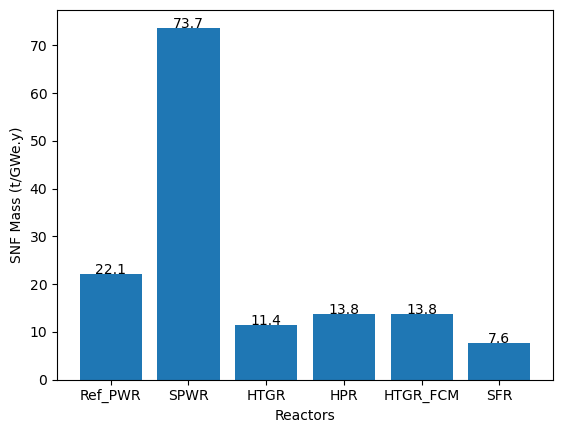

In [4]:
# Create a bar chart with the values of the SNF mass for each reactor

N_mass   = openmc_results[0].columns.get_loc("SNF mass (t/GWe.y)") # read the SNF mass index of columns in the dataframe
SNF_mass = [openmc_results[i].iloc[0,N_mass] for i in range(len(openmc_results))] # create a list with the SNF mass for each reactor
SNF_mass_labels = [round(x, 1) for x in SNF_mass]
plt.bar(x=reactors_legend, height=SNF_mass)
plt.xlabel('Reactors')
plt.ylabel('SNF Mass (t/GWe.y)') 
addlabels(reactors, SNF_mass_labels)
#plt.title ('Mass of spent nuclear fuel') 

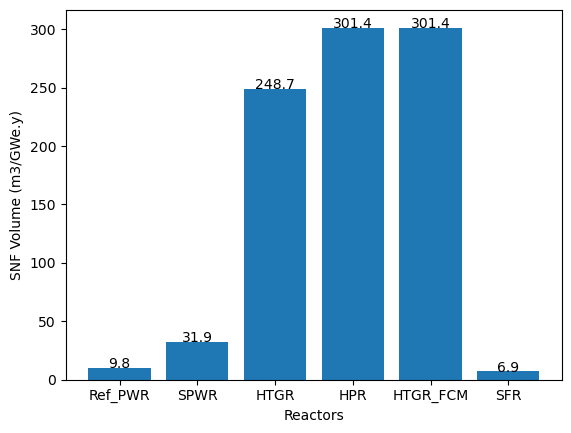

In [5]:
# Create a bar chart with the values of SNF volume for each reactor

N_vol    = openmc_results[0].columns.get_loc("SNF volume (m3/GWe.y)") # get the column index of the SNF volume in the dataframe
SNF_vol  = [openmc_results[i].iloc[0,N_vol] for i in range (len(openmc_results))] # create a list with the SNF volume
SNF_vol_labels = [round(x,1) for x in SNF_vol]
plt.bar(x = reactors_legend, height=SNF_vol)
plt.xlabel('Reactors')
plt.ylabel('SNF Volume (m3/GWe.y)') 
#plt.title ('Volume of spent nuclear fuel') 
addlabels(reactors, SNF_vol_labels)

# Activity

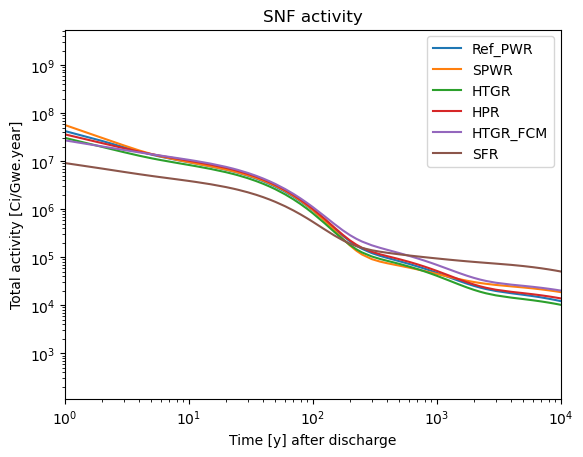

In [6]:
# Plot the evolution of the activity for each reactor after discharge

fig,ax = plt.subplots()
for i in openmc_results:
    i.plot(ax=ax, y=['Activity (Ci/GWe.y)'])
ax.set_xlabel('Time [y] after discharge')
ax.set_ylabel('Total activity [Ci/Gwe.year]') 
ax.set_title ('SNF activity') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1,1e4))
ax.legend(reactors)

# Decay heat

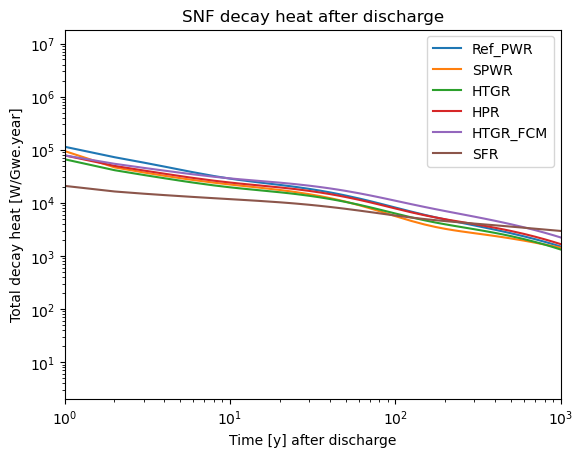

In [7]:
# Plot the evolution of the decay heat after discharge for each reactor
fig,ax= plt.subplots()
for i in openmc_results:
    i.plot(ax=ax, y='Decay heat (W/GWe.y)')
ax.set_xlabel('Time [y] after discharge')
ax.set_ylabel('Total decay heat [W/Gwe.year]') 
ax.set_title ('SNF decay heat after discharge') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1,1e3))
ax.legend(reactors)

# Radiotoxicity

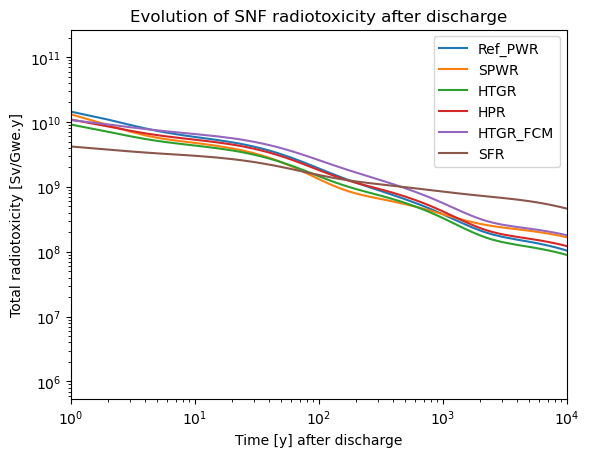

In [8]:
# Plot the evolution of the total radiotoxicity after discharge for each reactor

fig,ax = plt.subplots()
for i in openmc_results:
    i.plot(ax=ax, y='Radiotoxicity (Sv/GWe.y)')
ax.set_xlabel('Time [y] after discharge')
ax.set_ylabel('Total radiotoxicity [Sv/Gwe.y]') 
ax.set_title ('Evolution of SNF radiotoxicity after discharge') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1,1e4))
ax.legend(reactors)

# Repository

In [9]:
min_footprint_50 = pd.read_csv(workspace_path + 'results/footprint_minimization/min_footprint_50.csv')
min_footprint_50

,Years,#packages per GWe.y,Area per package (m2),Total area (m2),Required st (y),n_wf,Decay heat (W/Pkg),Reactor
0,50.0,48.09,23.71,1.14e-03,6.0,1,285.42,Ref_PWR
1,50.0,40.07,23.90,9.58e-04,3.0,4,262.14,SPWR
2,50.0,31.58,23.97,7.57e-04,2.0,42,329.14,HTGR
3,50.0,38.28,24.86,9.51e-04,2.0,42,336.20,HPR
4,50.0,36.23,40.64,1.47e-03,4.0,18,463.02,HTGR_FCM
5,50.0,25.75,33.04,8.51e-04,1.0,3,299.24,SFR


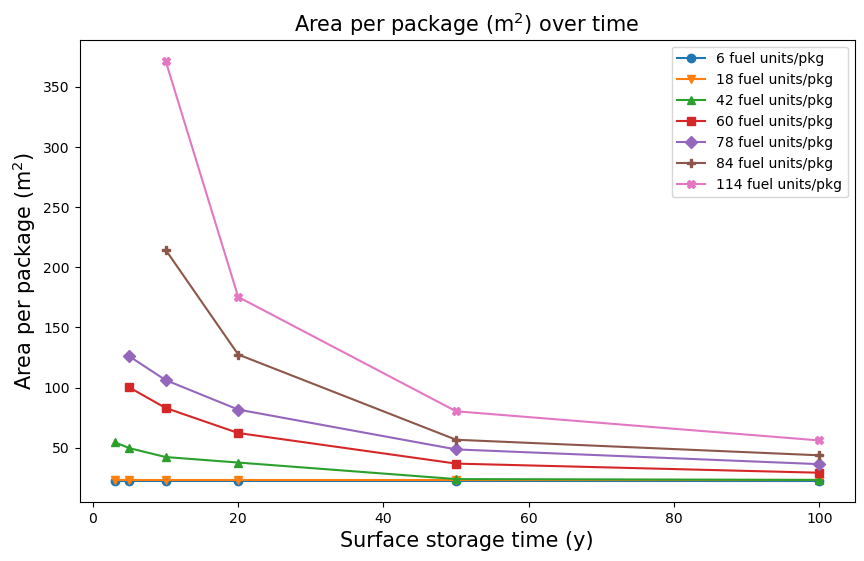

In [10]:
markers=['o', 'v', '^', 's', "D", "P", "X", '.', 'p', '8']

# Plotting
plt.figure(figsize=(10, 6))

for i, (n_wf, group) in enumerate(footprint_results.groupby('n_wf')):
    filter_group = group[group['Area per package (m2)'] > 0]
    #print(filter_group)
    plt.plot(filter_group['Years'], filter_group['Area per package (m2)'], label=f'{n_wf} fuel units/pkg', marker = markers[i])

plt.title(r'Area per package (m$^2$) over time', fontsize = 15)
plt.xlabel('Surface storage time (y)', fontsize = 15)
plt.ylabel(r'Area per package (m$^2$)', fontsize = 15)
plt.legend(loc = 'best')

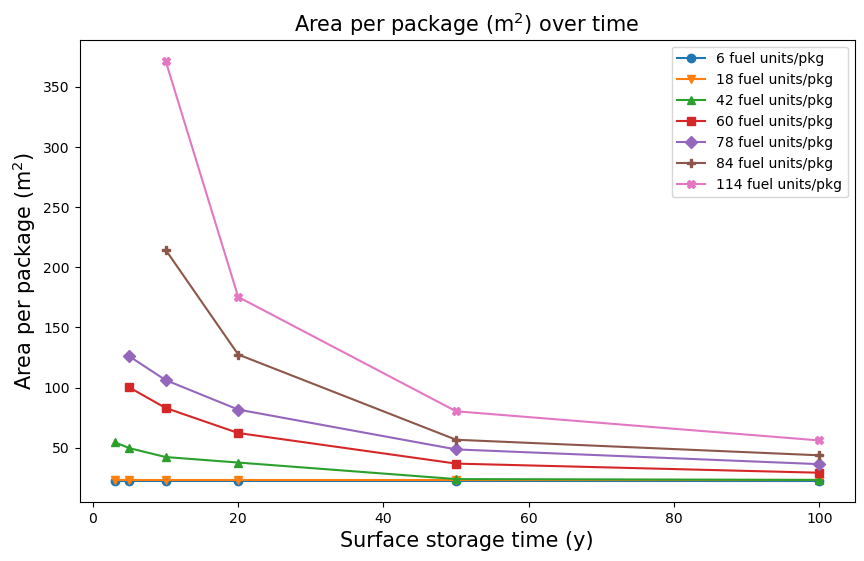

In [11]:
markers=['o', 'v', '^', 's', "D", "P", "X"]

# Plotting
plt.figure(figsize=(10, 6))

for i, (n_wf, group) in enumerate(footprint_results.groupby('n_wf')):
    filter_group = group[group['Area per package (m2)'] > 0]
    plt.plot(filter_group['Years'], filter_group['Area per package (m2)'], label=f'{n_wf} fuel units/pkg', marker = markers[i])

plt.title(r'Area per package (m$^2$) over time', fontsize = 15)
plt.xlabel('Surface storage time (y)', fontsize = 15)
plt.ylabel(r'Area per package (m$^2$)', fontsize = 15)
plt.legend(loc = 'best')

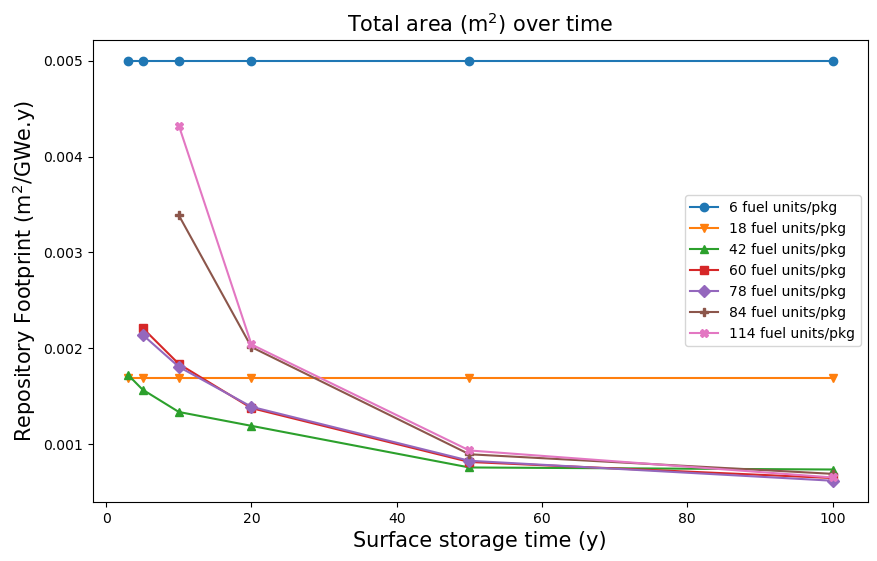

In [12]:
# Plotting
plt.figure(figsize=(10, 6))

for i, (n_wf, group) in enumerate(footprint_results.groupby('n_wf')):
    filter_group = group[group['Area per package (m2)'] > 0]
    plt.plot(filter_group['Years'], filter_group['Total area (m2)'], label=f'{n_wf} fuel units/pkg', marker = markers[i])

plt.title(r'Total area (m$^2$) over time', fontsize = 15)
plt.xlabel('Surface storage time (y)', fontsize = 15)
plt.ylabel(r'Repository Footprint (m$^2$/GWe.y)', fontsize = 15)
plt.legend(loc = 'best')

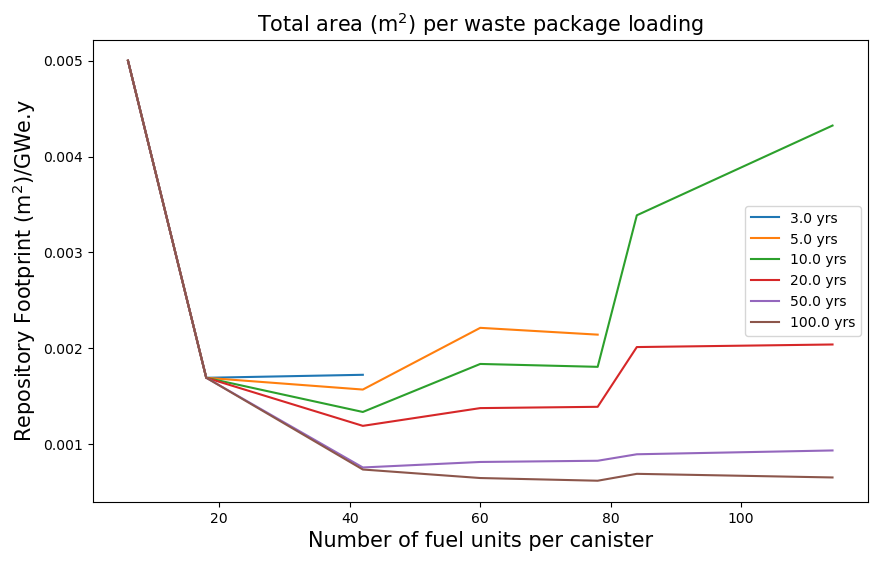

In [13]:
# Plotting
plt.figure(figsize=(10, 6))

for i, (st, group) in enumerate(footprint_results.groupby('Years')):
    filter_group = group[group['Area per package (m2)'] > 0].sort_values('n_wf')
    plt.plot(filter_group['n_wf'], filter_group['Total area (m2)'], label=f'{st} yrs') #, marker = markers[i])

plt.title(r'Total area (m$^2$) per waste package loading', fontsize = 15)
plt.xlabel('Number of fuel units per canister', fontsize = 15)
plt.ylabel(r'Repository Footprint (m$^2$)/GWe.y', fontsize = 15)
plt.legend(loc = 'best')

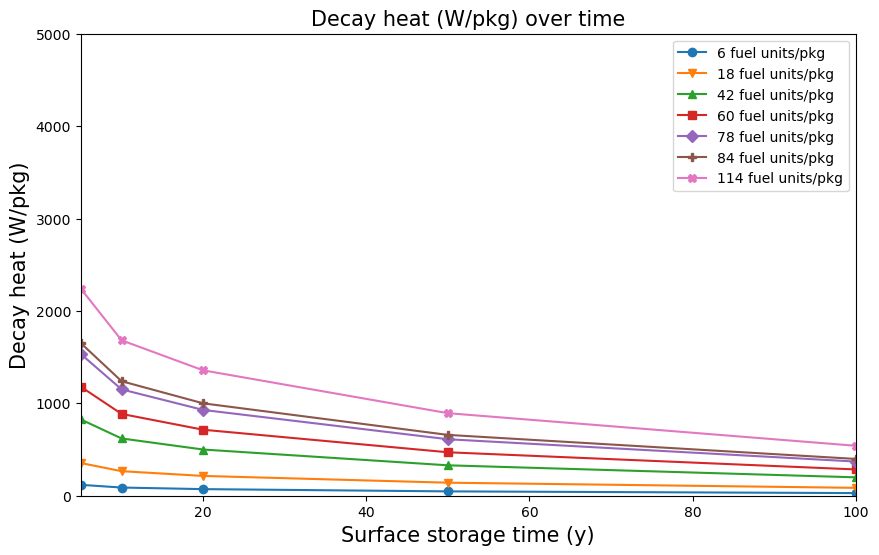

In [14]:
# Plotting
plt.figure(figsize=(10, 6))

for i, (n_wf, group) in enumerate(footprint_results.groupby('n_wf')):
    plt.plot(group['Years'], group['Decay heat (W/Pkg)'], label=f'{n_wf} fuel units/pkg', marker = markers[i])

plt.title(r'Decay heat (W/pkg) over time', fontsize = 15)
plt.xlabel('Surface storage time (y)', fontsize = 15)
plt.ylabel(r'Decay heat (W/pkg)', fontsize = 15)
plt.xlim([5, 100])
plt.ylim([0, 5000])
plt.legend(loc = 'best')

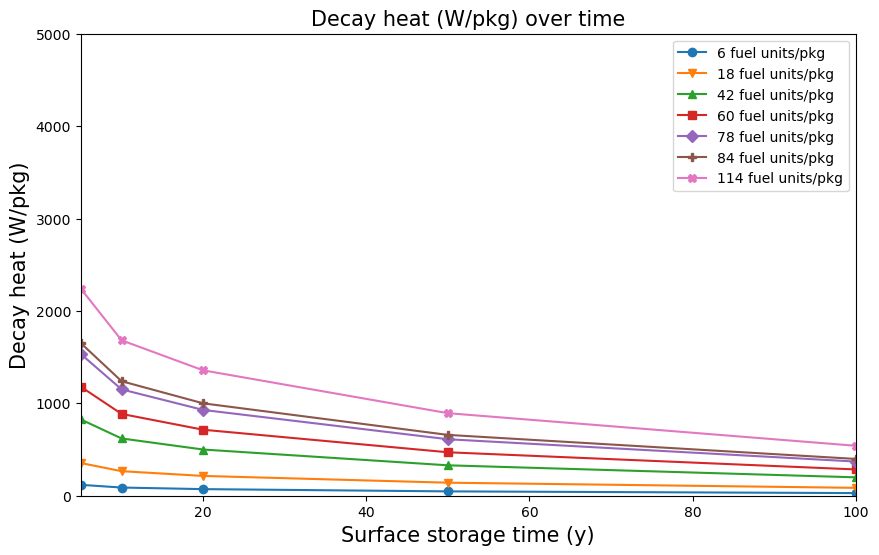

In [15]:
# Plotting
plt.figure(figsize=(10, 6))

for i, (n_wf, group) in enumerate(footprint_results.groupby('n_wf')):
    plt.plot(group['Years'], group['Decay heat (W/Pkg)'], label=f'{n_wf} fuel units/pkg', marker = markers[i])

plt.title(r'Decay heat (W/pkg) over time', fontsize = 15)
plt.xlabel('Surface storage time (y)', fontsize = 15)
plt.ylabel(r'Decay heat (W/pkg)', fontsize = 15)
plt.xlim([5, 100])
plt.ylim([0, 5000])
plt.legend(loc = 'best')

# I129

In [16]:
f_matrix_low = pd.read_csv(workspace_path + 'results/I129_release_transport/low_degradation/remaining_matrix.csv', index_col = 'Unnamed: 0')
f_matrix_high = pd.read_csv(workspace_path + 'results/I129_release_transport/high_degradation/remaining_matrix.csv', index_col = 'Unnamed: 0')

I129_release_can_low = pd.read_csv(workspace_path + 'results/I129_release_transport/low_degradation/I129_release.csv', index_col = 'Unnamed: 0')
I129_release_can_high = pd.read_csv(workspace_path + 'results/I129_release_transport/high_degradation/I129_release.csv', index_col = 'Unnamed: 0')

I129_release_GWey_low = pd.read_csv(workspace_path + 'results/I129_release_transport/low_degradation/I129_release_GWey_50.csv', index_col = 'Unnamed: 0')
I129_release_GWey_high = pd.read_csv(workspace_path + 'results/I129_release_transport/low_degradation/I129_release_GWey_50.csv', index_col = 'Unnamed: 0')

I129_conc = pd.read_csv(workspace_path + 'results/I129_release_transport/PFLOTRAN_output.csv', index_col = 'Time [y]')
I129_conc_GWey = pd.read_csv(workspace_path + 'results/I129_release_transport/PFLOTRAN_output_GWey.csv', index_col = 'Time [y]')

I129_dose_max = pd.read_csv(workspace_path + 'results/I129_release_transport/I129_dose_max.csv')
I129_dose_max_GWey = pd.read_csv(workspace_path + 'results/I129_release_transport/I129_dose_max_GWey.csv')
I129_dose_max_YM = pd.read_csv(workspace_path + 'results/I129_release_transport/I129_dose_max_YM.csv')

In [17]:
I129_dose_max_GWey

,Ref_PWR,SPWR,HTGR,HPR,HTGR_FCM,SFR
0,1.03e-16,6.76e-17,2.24e-20,2.53e-20,3.73e-20,2.23e-16


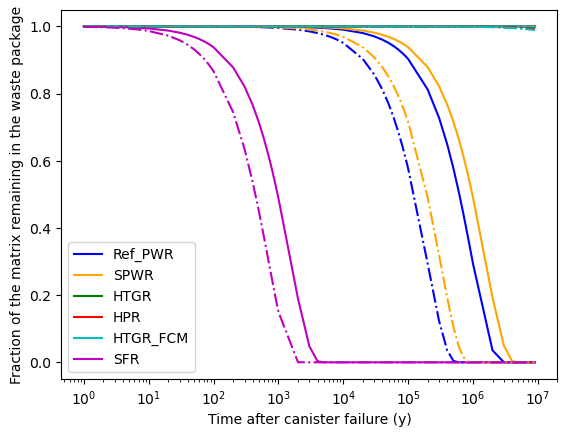

In [18]:
# Plot the fraction of the matrix remaining in the waste package 
fig, ax=plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

f_matrix_low.plot(ax=ax, linestyle='-', color=color)
f_matrix_high.plot(ax=ax, linestyle='-.', color=color)
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('Fraction of the matrix remaining in the waste package')
ax.set_xscale('log')

ax.legend(reactors_legend)

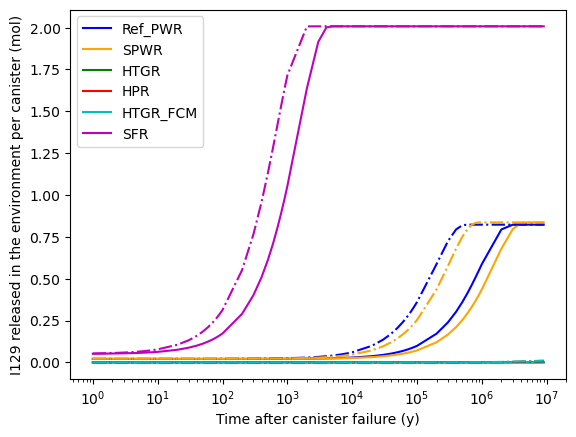

In [19]:
# Plot the quantity of I129 released in the environment per canister in the clay repository, in the low and high conditions
fig, ax=plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_release_can_low.plot(ax=ax, linestyle='-', color=color)
I129_release_can_high.plot(ax=ax, linestyle='-.', color=color)
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129 released in the environment per canister (mol)')
ax.set_xscale('log')
ax.legend(reactors_legend)

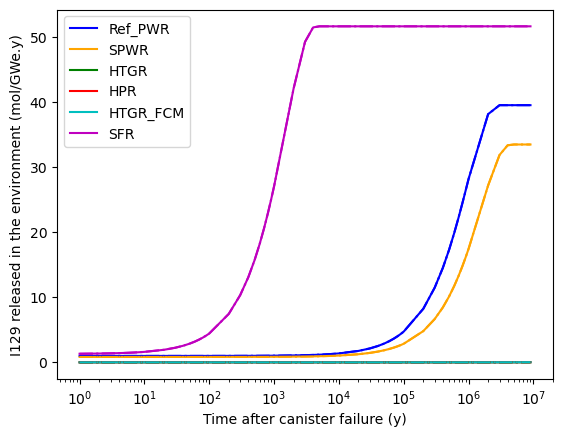

In [20]:
# Plot the I129 mass release for a repository containing the equivalent of 1 GWe.year electricity
fig, ax= plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_release_GWey_low.plot(linestyle='-', color=color, ax=ax)
I129_release_GWey_high.plot(linestyle='-.',color=color, ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129 released in the environment (mol/GWe.y)')
ax.legend(reactors_legend)

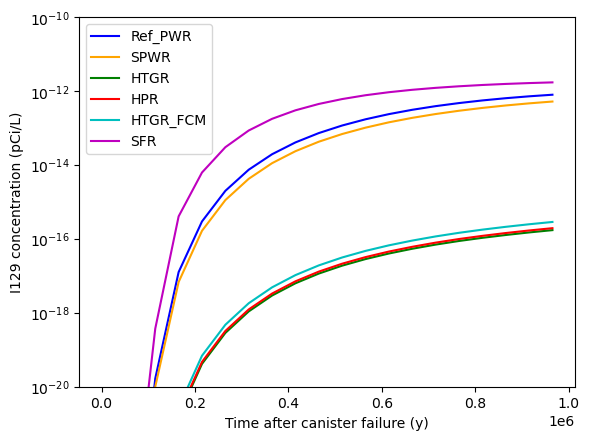

In [21]:
# Plot the I129 concentrations from a repository for different reactor types
fig, ax= plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_conc.plot(linestyle='-', color=color, ax=ax)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-20,1e-10))#
#ax.set_xlim((1e5,1e6))
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129 concentration (pCi/L)')
ax.legend(reactors_legend)

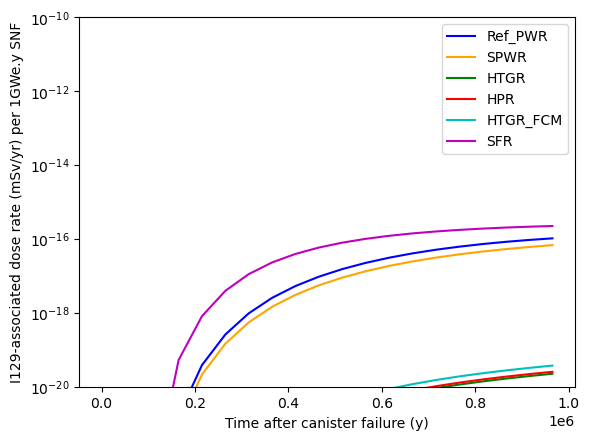

In [22]:
# Plot the I129-associated dose from a repository containing the equivalent of 1 GWe.year electricity
fig, ax= plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_conc_GWey.plot(linestyle='-', color=color, ax=ax)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-20,1e-10))#
#ax.set_xlim((1e5,1e6))
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129-associated dose rate (mSv/yr) per 1GWe.y SNF')
ax.legend(reactors_legend)

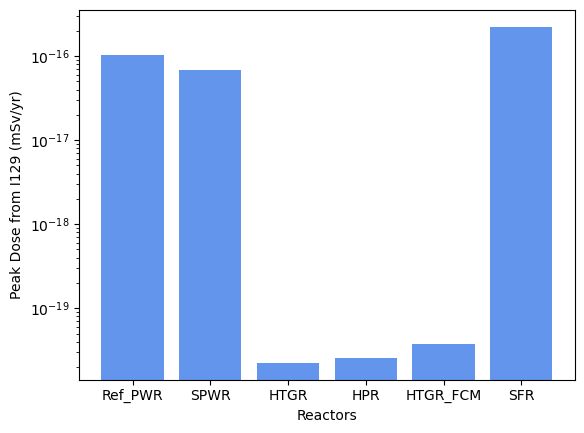

In [23]:
# Peak annual dose per the 1GWe.y-equivalent SNF

plt.bar(x=reactors_legend,height=I129_dose_max_GWey.iloc[0,:], color='cornflowerblue')
plt.xlabel('Reactors')
plt.ylabel('Peak Dose from I129 (mSv/yr)')
plt.yscale('log')

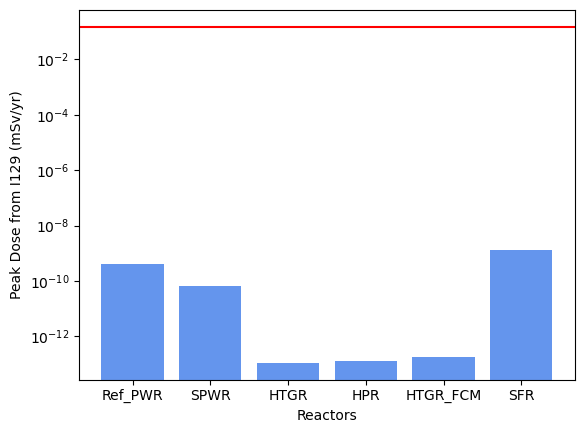

In [24]:
# Peak annual dose for YM after scaling the results to 70,000 MTHM
guideline = 0.15 # YM criteria mSv/yr

plt.bar(x=reactors_legend,height=I129_dose_max_YM.iloc[0,:], color='cornflowerblue')
plt.axhline(y=guideline, color='r')
plt.xlabel('Reactors')
plt.ylabel('Peak Dose from I129 (mSv/yr)')
plt.yscale('log')

# Summary of the results and comparison with the reference

In [25]:
# Enable to select the nearest index to the time in the results
## for example to select the activity at 10y, return the index the closest to 10 y and the corresponding value

def select_time(result, time):
    res=result.copy(deep=True)
    res['time']=res.index.tolist()
    idx= res['time'].sub(time).abs().idxmin()
    return idx
    

In [26]:
# Create a dataframe with the parameters of interest and select the corresponding values for each reactor

df = []
for i in range (len(openmc_results)): # iterate on the list of reactors
    result=openmc_results[i].copy(deep=True)
    d = []
    d.append(SNF_mass[i])
    d.append(SNF_vol[i])    
    idx=select_time(result, 50) # select the index for 10y
    d.append(result.loc[idx, 'Decay heat (W/GWe.y)'])
    
    idx=select_time(result, 10000) # Select the index for 100,000 years
    d.append(result.loc[idx, 'Radiotoxicity (Sv/GWe.y)'])
    
    d.append(min_footprint_50.iloc[i,1]) # footprint
    d.append(I129_dose_max_GWey.iloc[0,i])

    df.append(d)
    
df=pd.DataFrame(df, columns=['SNF mass (t/GWe.y)','SNF volume(m3/GWe.y)', 'Decay heat 50y (W/GWe.year)',
                           'Radiotoxicity 10000y (Sv/GWe.y)','Repo. Footprint, m^2','Peak dose rate, (mSv/yr)/GWe.y'])
df.index=reactors

In [27]:
df

,SNF mass (t/GWe.y),SNF volume(m3/GWe.y),Decay heat 50y (W/GWe.year),Radiotoxicity 10000y (Sv/GWe.y),"Repo. Footprint, m^2","Peak dose rate, (mSv/yr)/GWe.y"
Ref_PWR,22.12,9.76,13725.90,1.04e+08,48.09,1.03e-16
SPWR,73.74,31.93,10505.13,1.67e+08,40.07,6.76e-17
HTGR,11.41,248.66,10393.88,8.95e+07,31.58,2.24e-20
HPR,13.83,301.40,12868.83,1.22e+08,38.28,2.53e-20
HTGR_FCM,13.83,301.40,16775.64,1.80e+08,36.23,3.73e-20
SFR,7.60,6.94,7704.38,4.63e+08,25.75,2.23e-16


In [28]:
# Create a dataframe with the value of the ratio with the reference reactor

reference_reactor='Ref_PWR'
ratio=pd.DataFrame()
for i in df.columns:
    ref_value = df.loc[reference_reactor, i]
    ratio[i]  = df[i]/ref_value

ratio


,SNF mass (t/GWe.y),SNF volume(m3/GWe.y),Decay heat 50y (W/GWe.year),Radiotoxicity 10000y (Sv/GWe.y),"Repo. Footprint, m^2","Peak dose rate, (mSv/yr)/GWe.y"
Ref_PWR,1.00,1.00,1.00,1.00,1.00,1.00e+00
SPWR,3.33,3.27,0.77,1.60,0.83,6.54e-01
HTGR,0.52,25.49,0.76,0.86,0.66,2.17e-04
HPR,0.62,30.90,0.94,1.17,0.80,2.45e-04
HTGR_FCM,0.62,30.90,1.22,1.72,0.75,3.61e-04
SFR,0.34,0.71,0.56,4.43,0.54,2.16e+00


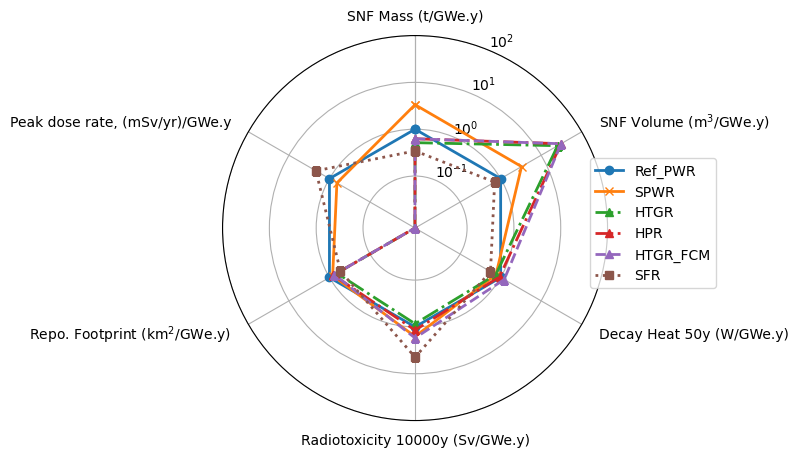

In [29]:
# Create a radar chart with the values of the ratio dataframe

# Set data
df = ratio.transpose()

category = df.index.tolist()
category =[*category, category[0]]

# For each reactor create a list with the values of the metrics
react=[]
for i in df.columns:
    l=df[i].tolist()
    l=[*l, l[0]]
    react.append(l)

# Set the location of the legend
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(category))

fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))

linestyle=['-', '-', '-.', '-.', '--', ':',':'] 
marker=["o", "x", "^", "^", "^", "s", "*", 'D']

# For each reactor, plot the line linking the parameters value
n=0
for i in react:
    ax.plot(label_loc, i, lw=2, ls=linestyle[n], marker=marker[n] )
    n+=1

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# align the labels
for label, angle in zip(ax.get_xticklabels(), label_loc):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')
ax.set_yscale('symlog', linthresh=0.1)
ax.set_ylim(0,100)


ax.legend(reactors_legend, loc='best', bbox_to_anchor=(1.3, 0.7), ncols=1)


labels_graph=['SNF Mass (t/GWe.y)','SNF Volume (m$^3$/GWe.y)', 'Decay Heat 50y (W/GWe.y)',
                           'Radiotoxicity 10000y (Sv/GWe.y)','Repo. Footprint (km$^2$/GWe.y)','Peak dose rate, (mSv/yr)/GWe.y','']

lines, labels = plt.thetagrids(np.degrees(label_loc), labels=labels_graph)



plt.show()